<div id="teaser" style=' background-position:  right center; background-size: 00px; background-repeat: no-repeat; 
    padding-top: 20px;
    padding-right: 10px;
    padding-bottom: 170px;
    padding-left: 10px;
    border-bottom: 14px double #333;
    border-top: 14px double #333;' > 

   
   <div style="text-align:center">
    <b><font size="6.4">Compressed sensing for identifying materials descriptors</font></b>    
  </div>
    
<p>
 created by:
 Emre Ahmetcik<sup>1</sup>, 
 Angelo Ziletti<sup>1</sup>,
 Runhai Ouyang<sup> 1</sup>,
 Luca Ghiringhelli<sup> 1</sup>,
 and Matthias Scheffler<sup>1</sup> <br><br>
   
<sup>1</sup> Fritz Haber Institute of the Max Planck Society, Faradayweg 4-6, D-14195 Berlin, Germany <br>
<span class="nomad--last-updated" data-version="v1.0.0">[Last updated: August 8, 2018]</span>
</p>

      
<div> 
<img  style="float: left;" src="data/Logo_MPG.png" width="200"> 
<img  style="float: right;" src="data/Logo_NOMAD.png" width="250">
</div>
</p>

</div>






This tutorial shows how to find descriptive parameters (short formulas) to predict materials properties using compressed sensing tools. As an example we adress the prediction of the relative stability of 82 zincblende (ZB) versus rocksalt (RS) octet binary materials.

The idea of using compressed sensing tools: Starting from simple physical quantities ("building blocks", here properties of the constituent free atoms such as orbital radii), millions (or billions) of candidate formulas are generated by applying arithmetic operations combining building blocks, for example forming sums and products of them. These candidate formulas constitute the so-called "feature space". Then a compressed sensing based method is used to select only a few of these formulas that explain the data, as introduced in 
<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
L. M. Ghiringhelli, J. Vybiral, S. V. Levchenko, C. Draxl, M. Scheffler: <span style="font-style: italic;">Big Data of Materials Science: Critical Role of the Descriptor</span>,  Phys. Rev. Lett. 114, 105503 (2015) <a href="http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.105503" target="_blank">[PDF]</a>.</div>
In this tutorial we use the Sure Independence Screening Sparse Operator  (SISSO) as proposed in
<div style="padding: 1ex; margin-top: 1ex; margin-bottom: 1ex; border-style: dotted; border-width: 1pt; border-color: blue; border-radius: 3px;">
R. Ouyang, S. Curtarolo, E. Ahmetcik, M. Scheffler, L. M. Ghiringhelli: <span style="font-style: italic;">SISSO: a compressed-sensing method for identifying the best low-dimensional descriptor in an immensity of offered candidates</span>, Phys. Rev. Materials  2, 083802 (2018) <a href="https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083802" target="_blank">[PDF]</a> .
</div>

# Introduction to the compressed sensing methods

The feature space is generated by creating a list of analytical expressions (the derived features), obtained by combining the primary features and arithmetic operations. We put all $m$ derived features into a descriptor matrix $\mathbf{D} \in \mathbb{R}^{82 \times m}$ where each column stands for a derived feature and each row for a compound. An $\ell_0$-regularization 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

determines those few feature columns which approximate a property vector $\mathbf{P} \in \mathbb{R}^{82}$ (i.e RS vs. ZB energy differences) best. The subscript 0 stays for the $\ell_0$-quasinorm, that counts the number of non-zero elements of $\mathbf{c}$ and $\lambda > 0$ is called the regularization parameter. Performing the $\ell_0$-regularization becomes fast computational infeasable and often approximations (i.e. LASSO, orthogonal matching pursuit) are needed since in practice the $\ell_0$-regularization needs to be solved combinatorial: All singletons, pairs, triplets, ... $n$-tuples (up to the selected maximum dimension of the descriptor) are listed and for each set a least-square regression is performed. The $n$-tuple that gives the lowest mean square error for the least-square regression fit is selected as the resulting $n$-dimensional descriptor.

### The LASSO method
A convex optimization problem can be introduced by the Least Absolute Shrinkage and Selection Operator (LASSO):

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Under certain conditions it can find a good approximation to the $\ell_0$-regularization.


### The SISSO method
SISSO works iteratively. In the first iteration, a number $k$ of features is collected that have the largest correlation (scalar product) with $\mathbf{P}$. The feature with the largest correlation is simply the 1D descriptor. Next, a residual is constructed as the error made at the first iteration. A new set of $k$ features is now selected as those having the largest correlation with the residual. The 2D descriptor is the pair of features that yield the smallest fitting error upon least-square regression, among all possible pairs contained in the union of the sets selected in this and the first iteration. In each next iteration a new residual is constructed as the error made in the previous iteration, then a new set of $k$ features is extracted as those that have largest correlation with each new residual. The $n$D descriptor is the $n$-tuple of features that yield the smallest fitting error upon least square regression, among all possible $n$-tuples contained in the union of the sets obtained in each new iteration and all the previous iterations. If $k=1$ the method collapses to the so-called orthogonal matching pursuit.


# Import required modules

In [1]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from time import time
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, LeaveOneOut

from modules.sisso import SissoRegressor
from modules.combine_features import combine_features
from modules.viewer import show_structure, show_map

# set display options for the notebook 
%matplotlib inline
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
%%javascript
// get path to notebook
Jupyter.notebook.kernel.execute(["notebookPath = ", "'", window.document.body.dataset.notebookPath, "'" ].join(''))

<IPython.core.display.Javascript object>

In [3]:
# go to notebook directory, this is needed to run the tutorial
base_dir = os.path.realpath(os.path.abspath(os.path.dirname(notebookPath)));
os.chdir(base_dir);

# Get the data
Let us load the data from the file data/data.pkl into a data frame. The data was downloaded from the NOMAD archive and the NOMAD atomic data collection. IT consists of RS-ZB energy differences (in eV/atom) of the 82 octet binary compounds, structure objects containing the atomic positions of the materials and properties of the atomic constituents. The following atomic features are considered:

<div >
   <ul>
      <li>Z:  atomic number</li>
      <li>period: period in the periodic table</li>
      <li>IP: electron affinity</li>
      <li>EA: ionization potential</li>      
      <li>E_HOMO: HOMO</li>
      <li>E_LUMO: LUMO</li>   
      <li>r_(s, p, d): radius at the maximum of the s, p or d orbital.</li>
   </ul>
</div>

In [4]:
# load data
df = pd.read_pickle("data/data.pkl")

# print data without structure objects
df.drop(['struc_obj_RS', 'struc_obj_ZB', 'struc_obj_min'], axis=1)

,energy_RS,energy_ZB,energy_diff,min_struc_type,Z(A),Z(B),period(A),period(B),IP(A),IP(B),...,E_HOMO(A),E_HOMO(B),E_LUMO(A),E_LUMO(B),r_s(A),r_s(B),r_p(A),r_p(B),r_d(A),r_d(B)
AgBr,-108781.333959,-108781.303925,-0.030033,RS,47.0,35.0,5.0,4.0,-8.0581,-12.649600,...,-4.710,-8.001,-0.479,0.708,1.32,0.75,1.88,0.88,2.97,1.87
AgCl,-79397.451083,-79397.408285,-0.042797,RS,47.0,17.0,5.0,3.0,-8.0581,-13.901800,...,-4.710,-8.700,-0.479,0.574,1.32,0.68,1.88,0.76,2.97,1.67
AgF,-74477.428165,-74477.274407,-0.153758,RS,47.0,9.0,5.0,2.0,-8.0581,-19.404301,...,-4.710,-11.294,-0.479,1.251,1.32,0.41,1.88,0.37,2.97,1.43
AgI,-171339.208181,-171339.245107,0.036925,ZB,47.0,53.0,5.0,5.0,-8.0581,-11.257100,...,-4.710,-7.236,-0.479,0.213,1.32,0.90,1.88,1.07,2.97,1.72
AlAs,-34200.077513,-34200.290775,0.213262,ZB,13.0,33.0,3.0,4.0,-5.7805,-9.261900,...,-2.784,-5.341,0.695,0.064,1.09,0.85,1.39,1.04,1.94,2.02
AlN,-4036.429049,-4036.501998,0.072949,ZB,13.0,7.0,3.0,2.0,-5.7805,-13.585200,...,-2.784,-7.239,0.695,3.057,1.09,0.54,1.39,0.51,1.94,1.54
AlP,-7940.862745,-7941.081704,0.218958,ZB,13.0,15.0,3.0,3.0,-5.7805,-9.750600,...,-2.784,-5.596,0.695,0.183,1.09,0.83,1.39,0.97,1.94,1.77
AlSb,-92644.192004,-92644.348873,0.156869,ZB,13.0,51.0,3.0,5.0,-5.7805,-8.468300,...,-2.784,-4.991,0.695,0.105,1.09,1.00,1.39,1.23,1.94,2.06
AsGa,-57457.679958,-57457.954236,0.274278,ZB,31.0,33.0,4.0,4.0,-5.8182,-9.261900,...,-2.732,-5.341,0.130,0.064,0.99,0.85,1.33,1.04,2.16,2.02
BAs,-31239.347344,-31240.222322,0.874978,ZB,5.0,33.0,2.0,4.0,-8.1900,-9.261900,...,-3.715,-5.341,2.248,0.064,0.81,0.85,0.83,1.04,1.95,2.02


In [5]:
# demonstrate 3x3x3 supercell of one example structure
example_structure = df.loc['AgBr', 'struc_obj_RS'] * [3, 3, 3]
show_structure(example_structure)

<!DOCTYPE html>
 
 
 <!-- load JSmol; relative path works, absolute fails, might be access rights related -->

Let us look at the distribution of the energy differences.

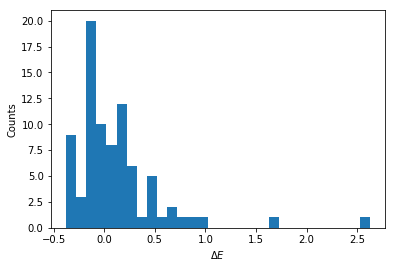

Standard deviation 0.44760288165780543


In [12]:
plt.hist(df['energy_diff'].tolist(), bins=30)
plt.xlabel('$\Delta E$')
plt.ylabel('Counts')
plt.show()
print('Standard deviation', df['energy_diff'].values.std())

With the SISSO method, we are able to predict the energy differences from the atomic features with an accuracy of 0.035 eV/atom. However, due to computational limit we will target an accuracy of around 0.1 eV/atom in this tutorial.  

Now let us define a function get_data that uses the data frame df_data to define the target vector $\mathbf{P}$ of energy differences and construct the desriptor matrix $\mathbf{D}$ of combined features. The arguments selected_feature_list and allowed_operations specify which primary features and which arithmetic operations should be used to build the new derived features.

In [15]:
def get_data(selected_feature_list, allowed_operations):
    # add both '(A)', '(B)' to each feature
    selected_featureAB_list = [f+A_or_B for f in selected_feature_list for A_or_B in ['(A)', '(B)']]
    
    # extract energy differences and selected features from df_data 
    P = df['energy_diff'].values
    df_features = df[selected_featureAB_list]
    
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

In [16]:
# selected_feature_list = ['IP', 'EA', 'E_HOMO', 'E_LUMO', 'r_s', 'r_p', 'r_d', 'Z', 'period', 'd']
selected_feature_list = ['r_s', 'r_p']

# allowed_operations = ['+', '-', '|-|', '*', '/' '^2', '^3',  'exp']
allowed_operations = ['+']

P, df_D = get_data(selected_feature_list, allowed_operations)

# print derived features
df_D

Selected operations:
 ['+']
Number of total features generated: 10


,r_s(A),r_s(B),r_p(A),r_p(B),(r_s(A)+r_s(B)),(r_s(A)+r_p(A)),(r_s(A)+r_p(B)),(r_s(B)+r_p(A)),(r_s(B)+r_p(B)),(r_p(A)+r_p(B))
AgBr,1.32,0.75,1.88,0.88,2.07,3.20,2.20,2.63,1.63,2.76
AgCl,1.32,0.68,1.88,0.76,2.00,3.20,2.08,2.56,1.44,2.64
AgF,1.32,0.41,1.88,0.37,1.73,3.20,1.69,2.29,0.78,2.25
AgI,1.32,0.90,1.88,1.07,2.22,3.20,2.39,2.78,1.97,2.95
AlAs,1.09,0.85,1.39,1.04,1.94,2.48,2.13,2.24,1.89,2.43
AlN,1.09,0.54,1.39,0.51,1.63,2.48,1.60,1.93,1.05,1.90
AlP,1.09,0.83,1.39,0.97,1.92,2.48,2.06,2.22,1.80,2.36
AlSb,1.09,1.00,1.39,1.23,2.09,2.48,2.32,2.39,2.23,2.62
AsGa,0.99,0.85,1.33,1.04,1.84,2.32,2.03,2.18,1.89,2.37
BAs,0.81,0.85,0.83,1.04,1.66,1.64,1.85,1.68,1.89,1.87


# Determining low-dimensional descriptors with the $\ell_0$ method

<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li> Perform an $\ell_0$-regularization to identify the best low dimensional descriptors using the primary features.</li>
<li> Show that non-linear functions of the primary features improve the models significantly. </li>
<li> See that the $\ell_0$-regularization can rapidly become computational infeasible.</li>
</div>

Our target is to find the best low dimensional descriptor for a linear model. The $\ell_0$ regularization

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

provides exactly what we want. It is defined in the follwing and solved combinatorial:

In [17]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

Perform the $\ell_0$-regularization for different dimensions (numbers of non-zero coefficients in the model) and see the root mean square errors (RMSE) and the selected features.

In [27]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

print("     RMSE   Best desriptor")
for dim in range(1,11):
    RMSE, coefficients, selected_indices = L0(P,D,dim)
    print('%2sD: %.3f' % (dim, RMSE), [features_list[i] for i in selected_indices])

No allowed operations selected.
Number of total features generated: 10
     RMSE   Best desriptor
 1D: 0.313 ['r_p(A)']
 2D: 0.295 ['r_p(A)', 'r_d(B)']
 3D: 0.280 ['r_s(B)', 'r_p(A)', 'r_p(B)']
 4D: 0.275 ['IP(B)', 'r_p(A)', 'r_p(B)', 'r_d(B)']
 5D: 0.263 ['IP(A)', 'IP(B)', 'r_p(A)', 'r_p(B)', 'r_d(B)']
 6D: 0.251 ['IP(A)', 'IP(B)', 'r_s(A)', 'r_p(A)', 'r_p(B)', 'r_d(B)']
 7D: 0.249 ['IP(A)', 'IP(B)', 'r_s(A)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
 8D: 0.249 ['EA(B)', 'IP(A)', 'IP(B)', 'r_s(A)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
 9D: 0.249 ['EA(A)', 'EA(B)', 'IP(A)', 'IP(B)', 'r_s(A)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']
10D: 0.249 ['EA(A)', 'EA(B)', 'IP(A)', 'IP(B)', 'r_s(A)', 'r_s(B)', 'r_p(A)', 'r_p(B)', 'r_d(A)', 'r_d(B)']


The result of performing the $\ell_0$-regularization shows that the accuracy converges fast, e.g. we could leave out some components in the linear model without descreasing the accuracy. The second observation is that a linear model of the atomic features is not enough to describe the RS-ZB energy differences. A way out could be using non-linear machine learning models, e.g. kernel ridge regression or a neural network, instead of linear regression. Another way is to put the non-linearity into the descriptors by building algebraic combinations of the atomic features and mapping the few best of these more complex features onto the target again with a linear model. 

Run the following script to build larger feature spaces of more complex features and select the best 1D, 2D and 3D desriptor for a linear model using $\ell_0$-regularization. Plot the results afterwards. How does the accuracy of the models change? How does the feature space size and the dimension of the descriptors depend on the needed time to solve the $\ell_0$-problem?

In [28]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
op_lists = [[], ['+','|-|'], ['+','|-|','exp'], ['+','|-|','exp', '^2'] ]
X  = []
Errors, Time = np.empty([3,len(op_lists)]), np.empty([3,len(op_lists)])

for n_op, allowed_operations in enumerate(op_lists):
    P, df_D = get_data(selected_feature_list, allowed_operations)
    features_list = df_D.columns.tolist()
    D = df_D.values
    
    number_of_features = len(features_list)
    X.append(number_of_features)
    for dim in range(1,4):
        t1= time()
        RMSE, coefficients, selected_indices = L0(P,D,dim)
        t2 = time()-t1             
        
        Time [dim-1][n_op] = t2
        Errors[dim-1][n_op] = RMSE 
        
        print("n_features: %s; %sD  RMSE: %.3f  best features: %s" 
              %(len(features_list), dim, RMSE, [features_list[i] for i in selected_indices]))

No allowed operations selected.
Number of total features generated: 10
n_features: 10; 1D  RMSE: 0.313  best features: ['r_p(A)']
n_features: 10; 2D  RMSE: 0.295  best features: ['r_p(A)', 'r_d(B)']
n_features: 10; 3D  RMSE: 0.280  best features: ['r_s(B)', 'r_p(A)', 'r_p(B)']
Selected operations:
 ['+', '|-|']
Number of total features generated: 52
n_features: 52; 1D  RMSE: 0.297  best features: ['(r_p(A)+r_d(B))']
n_features: 52; 2D  RMSE: 0.266  best features: ['(r_p(A)+r_d(B))', '|r_p(A)-r_d(B)|']
n_features: 52; 3D  RMSE: 0.210  best features: ['|r_s(A)-r_p(A)|', '(r_s(A)+r_d(B))', '(r_p(A)+r_d(B))']
Selected operations:
 ['+', '|-|', 'exp']
Number of total features generated: 73
n_features: 73; 1D  RMSE: 0.297  best features: ['(r_p(A)+r_d(B))']
n_features: 73; 2D  RMSE: 0.228  best features: ['(r_s(B)+r_p(A))', 'exp(r_s(B)+r_p(A))']
n_features: 73; 3D  RMSE: 0.201  best features: ['|r_s(B)-r_p(A)|', '|r_s(B)-r_p(B)|', 'exp(r_p(A))']
Selected operations:
 ['+', '|-|', 'exp', '^2'

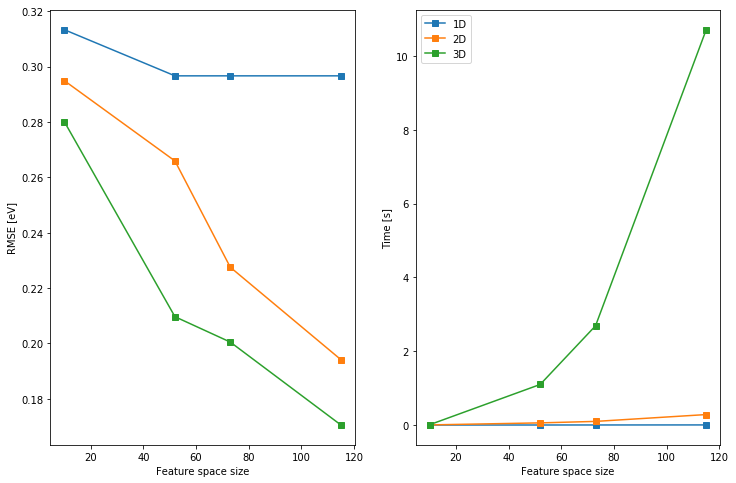

In [29]:
#plot
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(12,8))
ax1.set_xlabel('Feature space size')
ax2.set_xlabel('Feature space size')
ax1.set_ylabel('RMSE [eV/atom]')
ax2.set_ylabel('Time [s]')
#ax2.set_yscale('log')

for dim in range(1,4):
    ax1.plot(X, Errors[dim-1], 's-', label='%sD' %dim)
    ax2.plot(X, Time[dim-1], 's-', label='%sD' %dim)
ax2.legend(loc='best')
plt.show()

Assume now that we would like to include thousands or millions of (more) complex features to obtain more accurate models...

# Approximations to the $\ell_0$ method
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li >Perform a LASSO minimization and the SISSO method.</li>
<li >Compare the solutions with the ones from the $\ell_0$ method.</li>
</div>

### The LASSO


One state-of-the art approximation to the $\ell_0$ method is the LASSO: 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Before performing the LASSO regression we standardize the data to have mean 0 and variance 1, since otherwise the $\ell_2$-norm of a column would affect bias its contribution to the model. <br>
Note that we can use the LASSO also only for feature selection. We use then a least-square model with the selected features afterwards instead of the LASSO model directly.

In [30]:
def lasso_fit(lam, P, D, feature_list):
    #LASSO
    D_standardized = ss.zscore(D)
    lasso =  Lasso(alpha=lam)
    lasso.fit(D_standardized, P)
    coef =  lasso.coef_
    
    # get strings of selected features
    selected_indices = coef.nonzero()[0]
    selected_features = [feature_list[i] for i in selected_indices]
    
    # get RMSE of LASSO model
    P_predict = lasso.predict(D_standardized)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(82.)

    #get RMSE for least-square fit
    D_new = D[:, selected_indices]
    D_new = np.column_stack((D_new, np.ones(82)))
    RMSE_LS = np.sqrt(np.linalg.lstsq(D_new,P)[1][0]/82.)
        
    return RMSE_LASSO, RMSE_LS, coef, selected_features

$\lambda$ regulates the sparsity of the coefficient vector of the model. Get the data and try different $\lambda$ by adjusting the varibale lam. How good does LASSO (directly or with a least-square fit afterwards) approximate the L0-method (when the same feature space is used for both)?

In [31]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

Selected operations:
 ['+', '|-|', 'exp', '^2']
Number of total features generated: 115


lambda: 0.200	 dimension of descriptor: 2	 RMSE_LASSO: 0.357	 RMSE_LS: 0.291
   abs(nonzero_coefs_LASSO)         features
0                  0.017879  (r_p(A)+r_p(B))
1                  0.119307  (r_p(A)+r_d(B))


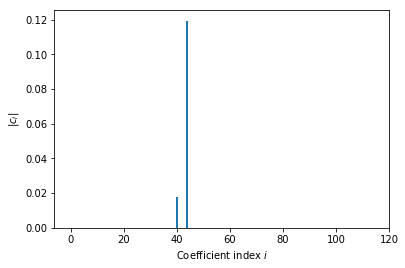

In [32]:
# change lam between 0.02 and 0.34, e.g. 0.34, 0.30, 0.20, 0.13, 0.10, 0.02
lam = 0.2

RMSE_LASSO, RMSE_LS, coef, selected_features = lasso_fit(lam, P, D, features_list)
plt.bar(range(len(coef)), np.abs(coef))
plt.xlabel("Coefficient index $i$")
plt.ylabel("$|c_i|$")

print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
      %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
plt.show()    

Hint:
Compare these results to the L0 results you have obtained before from the same feature space, copied and pasted in here:<br>
"Number of total features generated: 115 <br>
features: 115; 1D  RMSE: 0.296667841349  best features: ['(r_p(A)+r_d(B))'] <br>
features: 115; 2D  RMSE: 0.194137970112  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2'] <br>
features: 115; 3D  RMSE: 0.170545592998  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2', 'exp(r_s(B)+r_p(A))']"

### The SISSO method

In [33]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

Selected operations:
 ['+', '|-|', 'exp', '^2']
Number of total features generated: 115


Now apply the SISSO algorithm. How does the SISSO method compare to the LASSO and to the $\ell_0$-regularization in terms of accuracy (again when using the same feature space)? How fast is SISSO compared to the $\ell_0$-regularization? How does n_features_per_sis_iter (the number of features collected per sis iteration) affect the performance? Note, that for n_features_per_sis_iter=1 SISSO becomes the so-called orthogonal matching pursuit, another well-known compressed sensing method.

In [34]:
sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)

sisso.fit(D, P)
sisso.print_models(features_list)

          RMSE            Model
1D:	0.296668	- 0.484 (r_p(A)+r_d(B)) + 1.944
2D:	0.218070	- 3.483 (r_p(A)+r_d(B)) + 0.392 (r_p(A)+r_d(B))^2 + 7.495
3D:	0.193928	- 3.528 (r_p(A)+r_d(B)) + 0.405 (r_p(A)+r_d(B))^2 + 0.293 |r_s(A)-r_d(B)| + 7.280


# Run the SISSO method with a big feature space
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Reproduce the results from the <a href="http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.105503" target="_blank">reference publication</a>  by including further features.</li>
<li>Visualize the 2D descriptors in a structure map.</li>
<li>Experiment with different settings and investigate the influence of the input parameters on the results. (OPTIONAL)</li>
</div>
Note the size of the feature space, the needed time to run the code and the accuracy (using the default settings)!

In [35]:
# parameters for feature space construction
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = ['+','|-|','exp','^2', '/']

# get the data
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=26)

sisso.fit(D, P)
sisso.print_models(features_list)

Selected operations:
 ['+', '|-|', 'exp', '^2', '/']
Number of total features generated: 3391
          RMSE            Model
1D:	0.137212	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.100216	+ 0.114 |IP(B)-EA(B)|/r_p(A)^2 - 1.482 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.145
3D:	0.076428	+ 0.109 |IP(B)-EA(B)|/r_p(A)^2 - 1.766 |r_s(A)-r_p(B)|/exp(r_s(A)) - 6.032 |r_s(B)-r_p(B)|/(r_p(B)+r_d(A))^2 - 0.005


Next, plot an interactive 2D structure map using the 2D descriptor. By <i>hovering</i> over a point in the plot, information regarding that system is displayed. By <i>clicking</i> a point, an interactive 3D visualization of the structure will be displayed below.

The markers represent the compounds and their colors the reference energy differences. How well does the descriptor separate the compounds with respect to their crystal structure?

In [36]:
# get 2d solution
P_predict = sisso.predict(D, dim=2)
D_selcted = df_D.values[:, sisso.l0_selected_indices[1]]
features = df_D.columns[sisso.l0_selected_indices[1]]

# plot 2D map 
show_map(df, D_selcted, P_predict, features)

<!DOCTYPE html>
 
 
 
 Molecule #0 

 <!-- load JSmol; relative path works, absolute fails, might be access rights related -->
 
 
 

 
 
 
 
 
 
 
 
 
 
 
 Chemical Formula 
 Structure Type 
 
 
   
 
 
 
 
 
 
 
 
 


 
 
 
 Chemical Formula 
 Structure Type

# Predicting new materials (extrapolation)
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Perform a leave-one-out cross-validation (LOOCV) using SISSO.</li>
<li>Analyze the prediction accuracy and how often the same descriptor is selected.</li>
</div>

We have seen that we can fit the energy differences of materials accurately. But what about predicting the energy difference of a 'new' material (which was not included when determining the model)? We test the prediction performance via LOOCV.  In a LOOCV for each material the following procedure is performed: the selected material is excluded, the model is built on the remaining materials and the model accurcy is tested on the excluded material. This means that we need to run SISSO function 82 times. <br>
Get the data in the next cell and run the LOOCV  one cell after. Note that running the LOOCV  could take up to ten minutes. Use the remaining two cells of this chapter to analyse the results.<br>
How is the prediction error compared to the fitting error? How often is the same descriptor selected? Are there materials which had a outlying high/low error?

In [37]:
# get the data
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = ['+','|-|','exp', '^2', '/']

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
chemical_formulas = df_D.index.tolist()
D = df_D.values

Selected operations:
 ['+', '|-|', 'exp', '^2', '/']
Number of total features generated: 3391


In [39]:
# Leave-one-out cross-validation
n_compounds = len(P)
dimensions = range(1, 4)
features_count = [[] for i in range(3)]
P_predict = np.empty([len(dimensions), n_compounds])

sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)
loo = LeaveOneOut()

for indices_train, index_test in loo.split(P):
    i_cv = index_test[0]
    print('%2s) Leave out %s: Ediff_ref = %.3f eV/atom' 
          % (index_test[0]+1, chemical_formulas[i_cv], P[i_cv]))
        
    sisso.fit(D[indices_train], P[indices_train])
    sisso.print_models(features_list)    
    
    for dim in dimensions:      
        features = [features_list[i] for i in sisso.l0_selected_indices[dim - 1]]
        predicted_value = sisso.predict(D[index_test], dim=dim)[0]
        
        features_count[dim-1].append( tuple(features) )        
        P_predict[dim-1, i_cv] = predicted_value
        
        print('Ediff_predicted(%sD) = %.3f eV/atom' %(dim, predicted_value))
    print('-----')

 1) Leave out AgBr: Ediff_ref = -0.030 eV/atom
          RMSE            Model
1D:	0.138036	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.116855	+ 0.117 |IP(B)-EA(B)|/r_p(A)^2 - 6.691 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.265
3D:	0.084763	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.391 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.118
Ediff_predicted(1D) = -0.009 eV/atom
Ediff_predicted(2D) = 0.006 eV/atom
Ediff_predicted(3D) = -0.000 eV/atom
-----
 2) Leave out AgCl: Ediff_ref = -0.043 eV/atom
          RMSE            Model
1D:	0.137927	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.116617	+ 0.116 |IP(B)-EA(B)|/r_p(A)^2 - 6.711 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.264
3D:	0.084761	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.388 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.118
Ediff_predicted(1D) = 0.011 eV/atom
Ediff_predicted(2D) = 0.034 eV/atom
Ediff_predicted(3D) = -0.012 eV/atom
-----
 3) Leave out AgF: Ediff_ref = -0.154 eV/atom
          RMSE     

          RMSE            Model
1D:	0.137994	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.333
2D:	0.116530	+ 0.116 |IP(B)-EA(B)|/r_p(A)^2 - 6.620 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.267
3D:	0.084632	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.240 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.385 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.120
Ediff_predicted(1D) = 0.468 eV/atom
Ediff_predicted(2D) = 0.419 eV/atom
Ediff_predicted(3D) = 0.454 eV/atom
-----
20) Leave out BeSe: Ediff_ref = 0.495 eV/atom
          RMSE            Model
1D:	0.137905	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.333
2D:	0.116107	+ 0.116 |IP(B)-EA(B)|/r_p(A)^2 - 6.579 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.267
3D:	0.084638	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.240 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.380 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.120
Ediff_predicted(1D) = 0.436 eV/atom
Ediff_predicted(2D) = 0.370 eV/atom
Ediff_predicted(3D) = 0.443 eV/atom
-----
21) Leave out BeTe: Ediff_ref = 0.469 eV/atom
          RMSE            Model
1D:	0.137820	- 0.055 (IP(A)+IP(B))/r_p

          RMSE            Model
1D:	0.134586	- 0.101 (IP(B)+EA(A))/r_p(A)^2 - 0.380
2D:	0.099977	+ 0.115 |IP(B)-EA(B)|/r_p(A)^2 - 1.437 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.150
3D:	0.075550	+ 0.109 |IP(B)-EA(B)|/r_p(A)^2 - 1.717 |r_s(A)-r_p(B)|/exp(r_s(A)) - 6.057 |r_s(B)-r_p(B)|/(r_p(B)+r_d(A))^2 - 0.010
Ediff_predicted(1D) = 0.375 eV/atom
Ediff_predicted(2D) = 0.105 eV/atom
Ediff_predicted(3D) = 0.116 eV/atom
-----
38) Leave out CuI: Ediff_ref = 0.205 eV/atom
          RMSE            Model
1D:	0.136996	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.335
2D:	0.115484	+ 0.117 |IP(B)-EA(B)|/r_p(A)^2 - 6.534 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.270
3D:	0.084429	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.240 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.373 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.122
Ediff_predicted(1D) = 0.050 eV/atom
Ediff_predicted(2D) = 0.038 eV/atom
Ediff_predicted(3D) = 0.129 eV/atom
-----
39) Leave out GaN: Ediff_ref = 0.433 eV/atom
          RMSE            Model
1D:	0.136889	- 0.055 (IP(A)+IP(B))/r_p(A)^2

          RMSE            Model
1D:	0.137844	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.331
2D:	0.113940	+ 0.116 |IP(B)-EA(B)|/r_p(A)^2 - 6.889 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.260
3D:	0.084791	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.383 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.119
Ediff_predicted(1D) = 0.010 eV/atom
Ediff_predicted(2D) = 0.179 eV/atom
Ediff_predicted(3D) = -0.037 eV/atom
-----
56) Leave out LiI: Ediff_ref = -0.022 eV/atom
          RMSE            Model
1D:	0.137752	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.334
2D:	0.116903	+ 0.117 |IP(B)-EA(B)|/r_p(A)^2 - 6.648 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.266
3D:	0.084732	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.240 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.389 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.120
Ediff_predicted(1D) = -0.105 eV/atom
Ediff_predicted(2D) = -0.041 eV/atom
Ediff_predicted(3D) = -0.058 eV/atom
-----
57) Leave out MgO: Ediff_ref = -0.232 eV/atom
          RMSE            Model
1D:	0.134610	- 0.055 (IP(A)+IP(B))

          RMSE            Model
1D:	0.138000	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.332
2D:	0.099521	+ 0.114 |IP(B)-EA(B)|/r_p(A)^2 - 1.520 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.138
3D:	0.075882	+ 0.109 |IP(B)-EA(B)|/r_p(A)^2 - 1.791 |r_s(A)-r_p(B)|/exp(r_s(A)) - 5.965 |r_s(B)-r_p(B)|/(r_p(B)+r_d(A))^2 - 0.001
Ediff_predicted(1D) = 0.117 eV/atom
Ediff_predicted(2D) = 0.230 eV/atom
Ediff_predicted(3D) = 0.196 eV/atom
-----
74) Leave out SnSi: Ediff_ref = 0.135 eV/atom
          RMSE            Model
1D:	0.138049	- 0.055 (IP(A)+IP(B))/r_p(A)^2 - 0.333
2D:	0.116895	+ 0.117 |IP(B)-EA(B)|/r_p(A)^2 - 6.684 |r_s(A)-r_p(B)|/exp(r_p(A)+r_d(A)) - 0.265
3D:	0.083711	+ 0.112 |IP(B)-EA(B)|/r_p(A)^2 - 0.242 (r_p(B)+r_d(A))/exp(r_d(A)^2) - 1.426 |r_s(A)-r_p(B)|/exp(r_s(A)) - 0.112
Ediff_predicted(1D) = 0.123 eV/atom
Ediff_predicted(2D) = 0.158 eV/atom
Ediff_predicted(3D) = 0.261 eV/atom
-----
75) Leave out SrO: Ediff_ref = -0.220 eV/atom
          RMSE            Model
1D:	0.137775	- 0.055 (IP(A)+IP(B))/r_p(A)

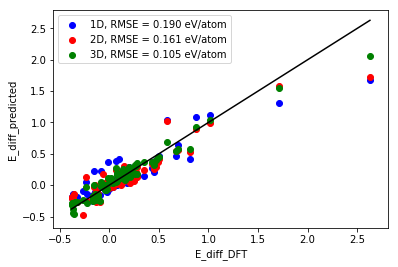

In [40]:
#Plot Prediction errors
prediction_errors = np.linalg.norm(P-P_predict, axis=1)/np.sqrt(n_compounds)
for dim in dimensions:
    predict = P_predict[dim-1]
    if dim == 1:
        maxi = max(max(P), max(predict))
        mini = min(min(P), min(predict))
        plt.plot([maxi,mini], [maxi,mini], 'k')
    plt.scatter(P, predict, color=['b','r', 'g'][dim-1], label='%sD, RMSE = %.3f eV/atom' %(dim, prediction_errors[dim-1]))
plt.legend(loc='best')
plt.xlabel('E_diff_DFT'), plt.ylabel('E_diff_predicted')
plt.show()

In [41]:
# Print descriptor selection frequency
print("Descriptor selection frequency")
for dim in dimensions:    
    df_frequency = pd.DataFrame( Counter(features_count[dim-1]).most_common(10), columns=['Features', 'Frequency'] )
    print('-----------------\n%sD:\n%s' % (dim, df_frequency))

# create table to display errors and models
feat = np.array(features_count).flatten('F')
Pred = np.array(P_predict).flatten('F')
Pred_errors = np.abs(P-P_predict).flatten('F')
Ref_values = [r for p in P for r in [p,p,p] ]
Mats = [m for mat in chemical_formulas for m in [mat, mat, mat] ]
Dims = ['1D','2D','3D'] * n_compounds

df_loo = pd.DataFrame(zip(Ref_values,Pred,Pred_errors,feat), index = [Mats,Dims],
                  columns=['P_ref[eV]', 'P_pred[eV]', 'abs. error [eV]', 'Selected features'])

#  if you do not want to sort the data frame by the prediction error comment out the nex line 
df_loo = df_loo.sort_values('abs. error [eV]', ascending=False)
pd.set_option('display.expand_frame_repr', False)

display(df_loo)

Descriptor selection frequency
-----------------
1D:
                             Features  Frequency
0           ((IP(A)+IP(B))/r_p(A)^2,)         75
1  ((IP(A)+IP(B))/(r_s(A)+r_p(A))^2,)          3
2           ((IP(B)+EA(A))/r_p(A)^2,)          2
3              (IP(B)/exp(r_p(A)^2),)          1
4      (|IP(B)-EA(B)|/exp(r_p(A)^2),)          1
-----------------
2D:
                                            Features  Frequency
0  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         60
1  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         17
2  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/r_s(A...          3
3  (|IP(B)-EA(B)|/exp(r_p(A)^2), r_d(A)/exp(r_d(A...          1
4  ((IP(A)+IP(B))/r_p(A)^2, (r_s(B)+r_d(A))/exp(r...          1
-----------------
3D:
                                            Features  Frequency
0  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...         54
1  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...         11
2  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(

P_ref[eV]  P_pred[eV]  abs. error [eV]                                  Selected features
C2   1D   2.628604    1.676269         0.952334                             (IP(B)/exp(r_p(A)^2),)
     2D   2.628604    1.731698         0.896906  (|IP(B)-EA(B)|/exp(r_p(A)^2), r_d(A)/exp(r_d(A...
     3D   2.628604    2.066737         0.561866  (|IP(B)-EA(B)|/exp(r_p(A)^2), |r_s(B)-r_p(B)|/...
BSb  1D   0.580849    1.032785         0.451936                          ((IP(A)+IP(B))/r_p(A)^2,)
     2D   0.580849    1.020137         0.439288  ((IP(A)+IP(B))/r_p(A)^2, (r_s(B)+r_d(A))/exp(r...
BN   1D   1.712080    1.303595         0.408486                 ((IP(A)+IP(B))/(r_s(A)+r_p(A))^2,)
GeC  1D   0.811443    0.416057         0.395386                          ((IP(A)+IP(B))/r_p(A)^2,)
CuF  1D  -0.017022    0.374862         0.391884                          ((IP(B)+EA(A))/r_p(A)^2,)
AgF  1D  -0.153758    0.223003         0.376760                          ((IP(B)+EA(A))/r_p(A)^2,)
MgO  2D  -0.232275    0.135412         0.367686  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
AlN  1D   0.072949    0.386358         0.313409                     (|IP(B)-EA(B)|/exp(r_p(A)^2),)
CdO  1D  -0.084161    0.228227         0.312389                 ((IP(A)+IP(B))/(r_s(A)+r_p(A))^2,)
ZnO  1D   0.101968    0.412408         0.310440                 ((IP(A)+IP(B))/(r_s(A)+r_p(A))^2,)
GeC  2D   0.811443    0.524250         0.287193  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
MgO  1D  -0.232275    0.045352         0.277627                          ((IP(A)+IP(B))/r_p(A)^2,)
LiF  2D  -0.059488    0.179284         0.238773  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
SnC  1D   0.453538    0.214814         0.238724                          ((IP(A)+IP(B))/r_p(A)^2,)
GeC  3D   0.811443    0.577123         0.234320  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
CaS  1D  -0.369133   -0.141738         0.227396                          ((IP(A)+IP(B))/r_p(A)^2,)
CaO  2D  -0.265219   -0.477739         0.212520  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
CaSe 1D  -0.360798   -0.150673         0.210125                          ((IP(A)+IP(B))/r_p(A)^2,)
MgO  3D  -0.232275   -0.022994         0.209281  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(B)-r_p(B)|/exp(r...
BAs  1D   0.874978    1.081913         0.206935                          ((IP(A)+IP(B))/r_p(A)^2,)
CaTe 2D  -0.350456   -0.146018         0.204438  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
SiC  1D   0.669024    0.468195         0.200829                          ((IP(A)+IP(B))/r_p(A)^2,)
AlN  3D   0.072949    0.271436         0.198487  (|IP(B)-EA(B)|/exp(r_p(A)^2), |r_s(A)-r_p(B)|/...
GaP  1D   0.348752    0.151172         0.197580                          ((IP(A)+IP(B))/r_p(A)^2,)
SrTe 2D  -0.379295   -0.183340         0.195955  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
SrS  1D  -0.368434   -0.177673         0.190761                          ((IP(A)+IP(B))/r_p(A)^2,)
SrSe 1D  -0.374511   -0.184851         0.189660                          ((IP(A)+IP(B))/r_p(A)^2,)
...            ...         ...              ...                                                ...
BAs  2D   0.874978    0.896316         0.021338  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
KI   1D  -0.167039   -0.187306         0.020267                          ((IP(A)+IP(B))/r_p(A)^2,)
KCl  3D  -0.164461   -0.184098         0.019637  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...
InP  3D   0.179193    0.198705         0.019512  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...
LiI  2D  -0.021661   -0.041075         0.019414  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
KBr  3D  -0.166176   -0.184529         0.018354  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...
NaI  2D  -0.114838   -0.133174         0.018336  (|IP(B)-EA(B)|/r_p(A)^2, |r_s(A)-r_p(B)|/exp(r...
BP   3D   1.019225    1.037372         0.018147  (|IP(B)-EA(B)|/r_p(A)^2, (r_p(B)+r_d(A))/exp(r...
CaS  3D  -0.369133   -0.386639         0.017506  

## Kernel ridge regession
Last but not least, compare the prediction (LOOCV) performance of SISSO to the one of kernel ridge regression with a gaussian kernel:

$K(x, y) = \exp(-\gamma ||x-y||^2)$

At each LOOCV step, the hyperparameters ($\ell_2$-regularization parameter and inverse gaussian width $\gamma$) are selected via a grid search and a so-called 5-fold cross-validation on the training set.

In [42]:
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

No allowed operations selected.
Number of total features generated: 10


In [54]:
kr = GridSearchCV(KernelRidge(kernel='rbf'), cv=5,
                  param_grid={"alpha": np.logspace(-3, 0, 5),
                              "gamma": np.logspace(-2, 1, 5)})
P_predict_kr = []
loo = LeaveOneOut()
for train_indices, test_index in loo.split(P):
    kr.fit(D[train_indices], P[train_indices])
    print("%2i Ediff_ref: %.3f, Ediff_pred: %.3f, hyperparameters: {'lambda': %.3f, 'gamma':%.3f}" 
          % (test_index[0], P[test_index], kr.best_params_['alpha'], 
          kr.best_params_['alpha'], kr.best_params_['gamma']))
    P_predict_kr.append(kr.predict(D[test_index])[0])


 0 Ediff_ref: -0.030, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 1 Ediff_ref: -0.043, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 2 Ediff_ref: -0.154, Ediff_pred: 0.178, hyperparameters: {'lambda': 0.178, 'gamma':0.056}
 3 Ediff_ref: 0.037, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 4 Ediff_ref: 0.213, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 5 Ediff_ref: 0.073, Ediff_pred: 0.178, hyperparameters: {'lambda': 0.178, 'gamma':0.056}
 6 Ediff_ref: 0.219, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 7 Ediff_ref: 0.157, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 8 Ediff_ref: 0.274, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
 9 Ediff_ref: 0.875, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.056}
10 Ediff_ref: 1.712, Ediff_pred: 0.032, hyperparameters: {'lambda': 0.032, 'gamma':0.010}
11 Edif

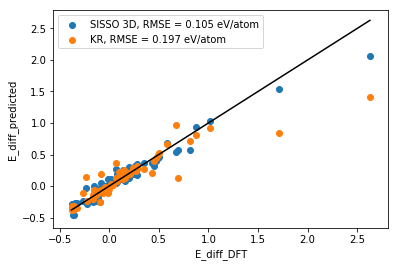

In [53]:
prediction_rmse_kr = np.linalg.norm(np.array(P_predict_kr) - P)/np.sqrt(P.size)

maxi = max(max(P), max(P_predict_kr))
mini = min(min(P), min(P_predict_kr))
plt.plot([maxi,mini], [maxi,mini], 'k')
plt.scatter(P, P_predict[-1], label='SISSO 3D, RMSE = %.3f eV/atom' % prediction_errors[dim-1])
plt.scatter(P, P_predict_kr,  label='KR, RMSE = %.3f eV/atom' % prediction_rmse_kr)
plt.xlabel('E_diff_DFT'), plt.ylabel('E_diff_predicted')
plt.legend()
plt.show()